In [1]:
import jax
from jax import numpy as jnp

jax.config.update("jax_enable_x64", True)

from matplotlib import pyplot as plt

from diffrax import Tsit5

from models import NeuralODE, MLPVectorField, GFINN, NMS, BasicParam
from system import SystemTrajectoryGenerator
from train import Trainer

print("JAX devices:", jax.devices())
print("Default backend:", jax.default_backend())

JAX devices: [CpuDevice(id=0)]
Default backend: cpu


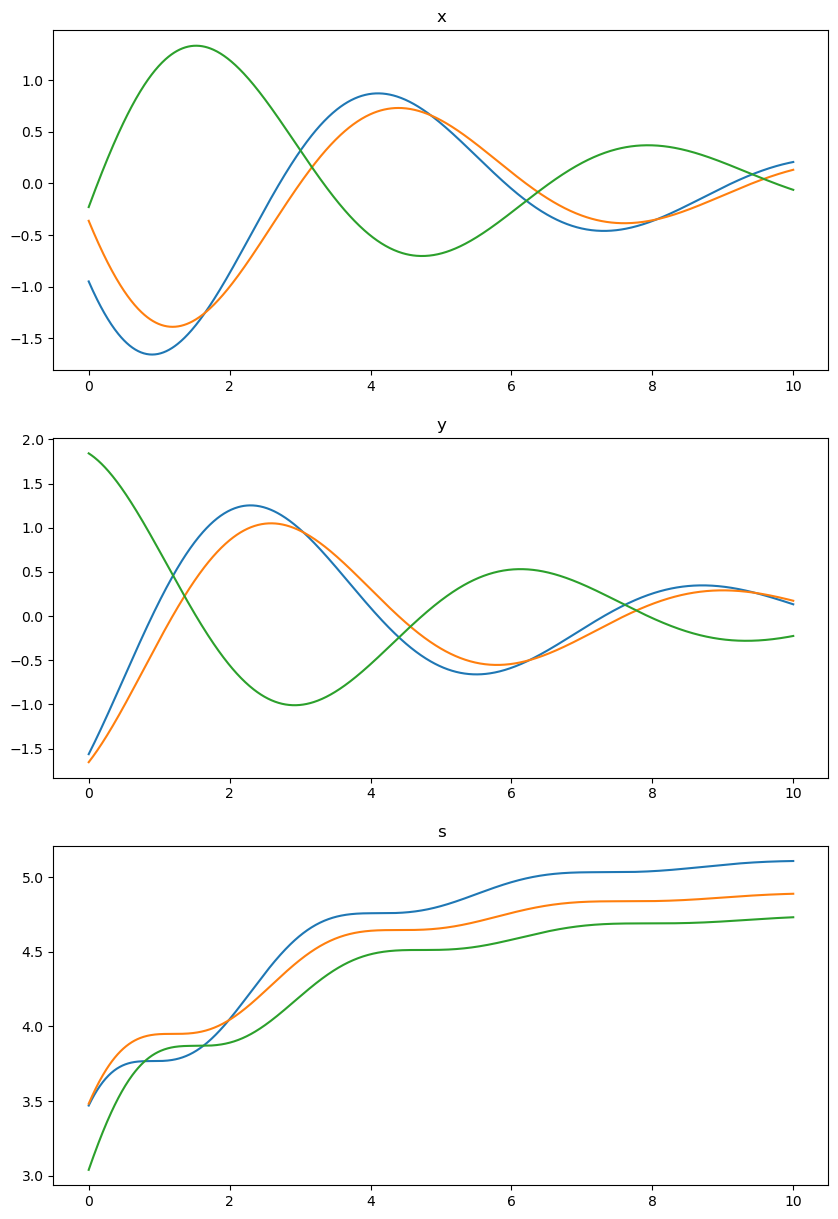

In [2]:
def vector_field(t,y,args):
    omega = 1.0
    zeta = 0.2
    return jnp.array([y[1],-(omega**2)*y[0]-2*zeta*omega*y[1],2*zeta*omega*y[1]**2])

dim = 3
system = SystemTrajectoryGenerator(vector_field, dim, Tsit5(), ["x", "y", "s"], args=())

key = jax.random.PRNGKey(42)
n_traj = 3
y0s = jax.random.uniform(key, (n_traj,dim)) * jnp.array([4,4,1]) + jnp.array([-2,-2,3])

y = system.generate_trajectories(y0s, 0, 10, 0.01)
system.plot_trajectories()

In [7]:
key = jax.random.PRNGKey(42)
model = NeuralODE(MLPVectorField, system.dim, 64, 2, 0.01, key=key)
trainer = Trainer(system, model=model, lr=1e-3, save_dir="mlp_dho/")
model, train_losses, valid_losses = trainer.train(N=2048, 
                                                  N_valid=4,
                                                  n_epochs=100, 
                                                  bs=32, 
                                                  bs_valid=2, 
                                                  mins=[-2,2,1], 
                                                  maxs=[2,2,3], 
                                                  ts_train=jnp.linspace(0, 10, 10000), 
                                                  dt=1e-3,
                                                  time_windows=[1, 10],
                                                  nrand=[100, 200],
                                                  save_every=10,
                                                  seed=42,
                                                  print_status=True,
                                                  save_plots=True)

--------------------

Training until time 1.000100010001, with 100 samples.

--------------------
Epoch: 0
Train loss: 0.05904403482491248, Valid loss: 0
--------------------
Epoch: 1
Train loss: 0.03172185302488368, Valid loss: 0
--------------------
Epoch: 2
Train loss: 0.009198218921691162, Valid loss: 0
--------------------
Epoch: 3
Train loss: 0.0026250666003851597, Valid loss: 0
--------------------
Epoch: 4
Train loss: 0.022274814741937807, Valid loss: 0
--------------------
Epoch: 5
Train loss: 0.00838208108343922, Valid loss: 0
--------------------
Epoch: 6
Train loss: 0.003225485463096362, Valid loss: 0
--------------------
Epoch: 7
Train loss: 0.0007855378193880965, Valid loss: 0
--------------------
Epoch: 8
Train loss: 0.0013354423448186865, Valid loss: 0
--------------------
Epoch: 9
Train loss: 0.0004101605476136396, Valid loss: 0
--------------------
Epoch: 10
Train loss: 0.009379861973900748, Valid loss: 0
Saving model at epoch 10
--------------------
Epoch: 11
Train l

In [3]:
key = jax.random.PRNGKey(0)
model = NeuralODE(GFINN, system.dim, 64, 2, 0.01, K=2, key=key)

def L2_loss_with_RHS(model, ti, yi):
    #y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:,0,:])
    #loss = ((yi - y_pred) ** 2).mean(axis=(1,2)).mean()
    loss = 0
    rhs_true = jax.vmap(vector_field, in_axes=(None, 0, None))(ti, yi[:,0,:], None)
    rhs_pred = jax.vmap(model.vector_field, in_axes=(None, 0, None))(ti, yi[:,0,:], None)
    rhs_loss = ((rhs_true - rhs_pred)**2).mean()
    lam = 1.0
    return (1-lam)*loss+lam*rhs_loss

trainer = Trainer(system, model=model, loss=L2_loss_with_RHS, lr=1e-3, save_dir="gfinn_dho/")
model, train_losses, valid_losses = trainer.train(N=2048, 
                                                  N_valid=4,
                                                  n_epochs=1000, 
                                                  bs=64,
                                                  bs_valid=2, 
                                                  mins=[-2,2,1], 
                                                  maxs=[2,2,3], 
                                                  ts_train=jnp.linspace(0, 10, 10000), 
                                                  dt=1e-3,
                                                  time_windows=[0.1, 0.1, 0.1, 0.1 , 0.1, 0.1, 10],
                                                  nrand=[100, 100, 100, 100, 100, 100, 200],
                                                  save_every=10,
                                                  seed=42,
                                                  print_status=True,
                                                  save_plots=True)

/Users/aballester3/Projects/NODE/synaptic/models.py:170: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.LgradS = GFINNComponent(dim, width, depth, K, "L", key=key1)
/Users/aballester3/Projects/NODE/synaptic/models.py:171: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.MgradE = GFINNComponent(dim, width, depth, K, "M", key=key2)


--------------------

Training until time 0.1000100010001, with 100 samples.

--------------------
Epoch: 0
Train loss: 0.5491751895361715, Valid loss: 0
--------------------
Epoch: 1
Train loss: 0.14146484480955276, Valid loss: 0
--------------------
Epoch: 2
Train loss: 0.15121362182319062, Valid loss: 0
--------------------
Epoch: 3
Train loss: 0.2297247990872195, Valid loss: 0
--------------------
Epoch: 4
Train loss: 0.04813916607281182, Valid loss: 0
--------------------
Epoch: 5
Train loss: 0.4964045707995912, Valid loss: 0
--------------------
Epoch: 6
Train loss: 0.07300352114579203, Valid loss: 0
--------------------
Epoch: 7
Train loss: 0.42648184659894905, Valid loss: 0
--------------------
Epoch: 8
Train loss: 0.27773043611231957, Valid loss: 0
--------------------
Epoch: 9
Train loss: 0.2698330216842636, Valid loss: 0
--------------------
Epoch: 10
Train loss: 0.09544237396917575, Valid loss: 0
Saving model at epoch 10
--------------------
Epoch: 11
Train loss: 0.02271160

In [4]:
L, dS = model.vector_field.LgradS(jnp.array([0.0, 0.0, 2.0]))
M, dE = model.vector_field.MgradE(jnp.array([0.0, 0.0, 2.0]))
print("L")
print(L)
print("dE")
print(dE)
print("M")
print(M)
print("dS")
print(dS)

print("L @ dS")
print(dS @ L)
print("M @ dE")
print(dE @ M)

print("Eigenvalues of M")
print(jnp.linalg.eigvalsh(M))

print("model vector field")
print(model.vector_field(0.0, jnp.array([0.0, 0.0, 2.0]), None))

L
[[ 1.04002011e-18 -3.46666135e-01 -3.26956786e-01]
 [ 3.46666135e-01  1.06759130e-17  1.05924976e-01]
 [ 3.26956786e-01 -1.05924976e-01 -1.57602876e-17]]
dE
[[-0.04468452  0.00044254 -0.16920552]]
M
[[ 0.04591511  0.01938883 -0.01207475]
 [ 0.01938883  0.03056432 -0.00504035]
 [-0.01207475 -0.00504035  0.00317557]]
dS
[[-0.0995682  -0.30733545  0.325862  ]]
L @ dS
[[-1.77529581e-17 -1.02239173e-17 -2.59523605e-17]]
M @ dE
[[-2.04053773e-19  5.49346376e-20  0.00000000e+00]]
Eigenvalues of M
[-1.54591639e-18  1.77564500e-02  6.18985503e-02]
model vector field
[ 0.04070422 -0.04638017 -0.01087065]


In [3]:
key = jax.random.PRNGKey(0)
model = NeuralODE(BasicParam, system.dim, 64, 2, 0.01, key=key)

def L2_loss_with_RHS(model, ti, yi):
    #y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:,0,:])
    #loss = ((yi - y_pred) ** 2).mean(axis=(1,2)).mean()
    loss = 0
    rhs_true = jax.vmap(vector_field, in_axes=(None, 0, None))(ti, yi[:,0,:], None)
    rhs_pred = jax.vmap(model.vector_field, in_axes=(None, 0, None))(ti, yi[:,0,:], None)
    rhs_loss = ((rhs_true - rhs_pred)**2).mean()
    lam = 1.0
    return (1-lam)*loss+lam*rhs_loss

trainer = Trainer(system, model=model, loss=L2_loss_with_RHS, lr=1e-3, save_dir="basic_dho/")
model, train_losses, valid_losses = trainer.train(N=2048, 
                                                  N_valid=4,
                                                  n_epochs=1000, 
                                                  bs=64,
                                                  bs_valid=2, 
                                                  mins=[-2,2,1], 
                                                  maxs=[2,2,3], 
                                                  ts_train=jnp.linspace(0, 10, 10000), 
                                                  dt=1e-3,
                                                  time_windows=[0.1, 0.1, 0.1, 0.1 , 0.1, 0.1, 10],
                                                  nrand=[100, 100, 100, 100, 100, 100, 200],
                                                  save_every=10,
                                                  seed=42,
                                                  print_status=True,
                                                  save_plots=True)

/Users/aballester3/Projects/NODE/synaptic/models.py:57: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.vector_field = vector_field_cls(dim=dim, width=width, depth=depth, key=key, **kwargs)


--------------------

Training until time 0.1000100010001, with 100 samples.

--------------------
Epoch: 0
Train loss: 0.3794890407580264, Valid loss: 0
--------------------
Epoch: 1
Train loss: 0.05110520242985772, Valid loss: 0
--------------------
Epoch: 2
Train loss: 0.10288610245897349, Valid loss: 0
--------------------
Epoch: 3
Train loss: 0.08721454279497053, Valid loss: 0
--------------------
Epoch: 4
Train loss: 0.03658468450678506, Valid loss: 0
--------------------
Epoch: 5
Train loss: 0.12849070083967706, Valid loss: 0
--------------------
Epoch: 6
Train loss: 0.028497996033132158, Valid loss: 0
--------------------
Epoch: 7
Train loss: 0.04813922284453233, Valid loss: 0
--------------------
Epoch: 8
Train loss: 0.0838384477727631, Valid loss: 0
--------------------
Epoch: 9
Train loss: 0.05764072904321502, Valid loss: 0
--------------------
Epoch: 10
Train loss: 0.00981575994637913, Valid loss: 0
Saving model at epoch 10
--------------------
Epoch: 11
Train loss: 0.00262

In [6]:
triu_indices_L = jnp.triu_indices(3, k=1)
triu_indices_M = jnp.triu_indices(3, k=0)
L_vals = model.vector_field.L(jnp.array([0.0, 0.0, 2.0]))
L = jnp.zeros((3,3))
L = L.at[triu_indices_L].set(L_vals)
L = L - L.T
M_vals = model.vector_field.M(jnp.array([0.0, 0.0, 2.0]))
M = jnp.zeros((3,3))
M = M.at[triu_indices_M].set(M_vals)
M = M.T@M
E = model.vector_field.energy(jnp.array([0.0, 0.0, 2.0]))
S = model.vector_field.entropy(jnp.array([0.0, 0.0, 2.0]))
print("L")
print(L)
print("dE")
#print(dE)
print("M")
print(M)
print("dS")
#print(dS)

print("L @ dS")
#print(dS @ L)
print("M @ dE")
#print(dE @ M)

print("Eigenvalues of M")
print(jnp.linalg.eigvalsh(M))

print("model vector field")
print(model.vector_field(0.0, jnp.array([0.0, 0.0, 2.0]), None))

L
[[ 0.          4.7070953  -0.0862208 ]
 [-4.7070953   0.         -0.11021576]
 [ 0.0862208   0.11021576  0.        ]]
dE
M
[[ 3.32186646  1.74075469 -0.62505454]
 [ 1.74075469  2.13843611  0.53903949]
 [-0.62505454  0.53903949  1.93096211]]
dS
L @ dS
M @ dE
Eigenvalues of M
[0.45334617 2.35396861 4.5839499 ]
model vector field
[-0.13926228 -0.09269367  0.06836706]


In [5]:
key = jax.random.PRNGKey(0)
model = NeuralODE(NMS, system.dim, 64, 2, 0.01, 
                  lE=2,
                  lS=2,
                  lA=2,
                  lB=2, 
                  lD=2, 
                  nE=32, 
                  nS=32, 
                  nA=32, 
                  nB=32, 
                  nD=32, 
                  D=3, 
                  C2=3, 
                  key=key)

print(model.vector_field(0, jnp.zeros((3, 3))).shape)

def L2_loss_with_RHS(model, ti, yi):
    y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:,0,:])
    loss = ((yi - y_pred) ** 2).mean(axis=(1,2)).mean()
    rhs_true = jax.vmap(vector_field, in_axes=(None, 0, None))(ti, yi[:,0,:], None)
    rhs_pred = jax.vmap(model.vector_field, in_axes=(None, 0, None))(ti, yi[:,0,:], None)
    rhs_loss = ((rhs_true - rhs_pred)**2).mean()
    lam = 0.2
    return (1-lam)*loss+lam*rhs_loss

trainer = Trainer(system, model=model, loss=L2_loss_with_RHS, lr=1e-3, save_dir="nms_dho/")
model, train_losses, valid_losses = trainer.train(N=2048, 
                                                  N_valid=4,
                                                  n_epochs=100, 
                                                  bs=32, 
                                                  bs_valid=2, 
                                                  mins=[-2,2,1], 
                                                  maxs=[2,2,3], 
                                                  ts_train=jnp.linspace(0, 10, 10000), 
                                                  dt=1e-3,
                                                  time_windows=[1, 10],
                                                  nrand=[100, 200],
                                                  save_every=10,
                                                  seed=42,
                                                  print_status=True,
                                                  save_plots=True)

TypeError: dot_general requires contracting dimensions to have the same shape, got (3,) and (1,).